In [4]:
import pandas as pd
import os, sys, email
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
emails_df = pd.read_csv('raw-email/my_raw_email.csv')
print(emails_df.shape)
emails_df.head()

(52076, 3)


,Unnamed: 0,text,class
0,beck-s/mgmt_summary/1,Message-ID: <26915956.1075855881514.JavaMail.e...,ham
1,beck-s/mgmt_summary/4,Message-ID: <21691016.1075855881596.JavaMail.e...,ham
2,beck-s/mgmt_summary/3,Message-ID: <21487147.1075855881568.JavaMail.e...,ham
3,beck-s/mgmt_summary/2,Message-ID: <29181475.1075855881541.JavaMail.e...,ham
4,beck-s/mgmt_summary/5,Message-ID: <25567863.1075855881620.JavaMail.e...,ham


In [6]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [7]:
emails_df.isnull().sum()

Unnamed: 0     0
text          14
class          0
dtype: int64

In [8]:
emails_df.dropna(inplace = True)

In [9]:
messages = list(map(email.message_from_string, emails_df['text']))
#print (messages)

emails_df.drop('text', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
print (keys)
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
#Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract email
#the root of 'file' as 'user'
#emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages


['Message-ID', 'Date', 'From', 'To', 'Subject', 'Cc', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'Bcc', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Origin', 'X-FileName']


In [10]:
emails_df.columns

Index(['Unnamed: 0', 'class', 'Message-ID', 'Date', 'From', 'To', 'Subject',
       'Cc', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding',
       'Bcc', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Origin', 'X-FileName',
       'content'],
      dtype='object')

In [11]:
emails_df = emails_df.set_index('Message-ID').drop(['Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'Bcc', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Origin', 'X-FileName', 'Cc'], axis=1)

In [12]:
emails_df.columns

Index(['Unnamed: 0', 'class', 'Date', 'From', 'To', 'Subject', 'content'], dtype='object')

In [13]:
emails_df['Unnamed: 0']

Message-ID
<26915956.1075855881514.JavaMail.evans@thyme>                                    beck-s/mgmt_summary/1
<21691016.1075855881596.JavaMail.evans@thyme>                                    beck-s/mgmt_summary/4
<21487147.1075855881568.JavaMail.evans@thyme>                                    beck-s/mgmt_summary/3
<29181475.1075855881541.JavaMail.evans@thyme>                                    beck-s/mgmt_summary/2
<25567863.1075855881620.JavaMail.evans@thyme>                                    beck-s/mgmt_summary/5
                                                                           ...                        
<000071251d3a$00003d4c$00003631@mailhost.trip.to>    SH/SA/20021010_spam/0361.eb828b44c428fcecd4e95...
<200207190806.g6J86er20831@www>                      SH/SA/20021010_spam/0039.256602e2cb5a5b373bdd1...
<p4kx9.mt1pdr@prodigy.net>                           SH/SA/20021010_spam/0312.a0e7f2633bd0ceaddf16f...
<000c52d43aad$4242a0b5$4ad47ca8@fyiink>              SH/SA/200

In [14]:
emails_df = emails_df.drop(['Unnamed: 0'], axis=1)

In [15]:
emails_df.columns

Index(['class', 'Date', 'From', 'To', 'Subject', 'content'], dtype='object')

In [16]:
emails_df['label'] = emails_df['class']
emails_df = emails_df.drop(['class'], axis=1)

In [17]:
emails_df.columns

Index(['Date', 'From', 'To', 'Subject', 'content', 'label'], dtype='object')

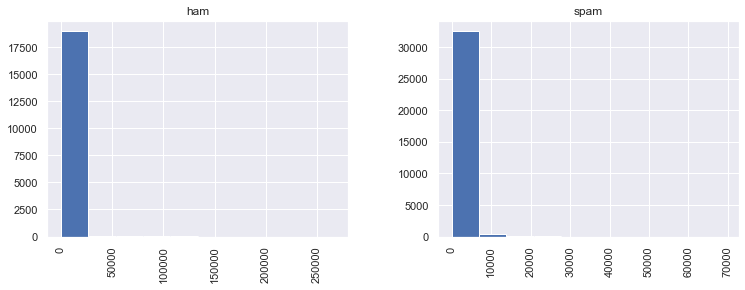

In [18]:
emails_df['length'] = emails_df['content'].apply(len)
sns.set()
emails_df.hist(column='length', by='label', bins=10,figsize=(12,4));

In [19]:
emails_df.columns

Index(['Date', 'From', 'To', 'Subject', 'content', 'label', 'length'], dtype='object')

In [20]:
emails_df.head(5)

,Date,From,To,Subject,content,label,length
Message-ID,,,,,,,
<26915956.1075855881514.JavaMail.evans@thyme>,"Fri, 28 Jul 2000 07:09:00 -0700 (PDT)",(darin.talley@enron.com),"(edward.ondarza@enron.com, mark.tawney@enron.c...",Mgmt Summary & Hot List,"Attached are the Mgmt. Summary, Hot List, and ...",ham,186
<21691016.1075855881596.JavaMail.evans@thyme>,"Fri, 9 Jun 2000 07:35:00 -0700 (PDT)",(darin.talley@enron.com),"(edward.ondarza@enron.com, mark.tawney@enron.c...",Mgmt Summary & HotList,"Attached are the Mgmt Summary, Hot List and Me...",ham,87
<21487147.1075855881568.JavaMail.evans@thyme>,"Fri, 16 Jun 2000 07:31:00 -0700 (PDT)",(darin.talley@enron.com),"(edward.ondarza@enron.com, mark.tawney@enron.c...",Mgmt Summary & Hot List,"Attached are the Mgmt Summary, Hot List and Me...",ham,84
<29181475.1075855881541.JavaMail.evans@thyme>,"Fri, 23 Jun 2000 05:58:00 -0700 (PDT)",(darin.talley@enron.com),"(edward.ondarza@enron.com, mark.tawney@enron.c...",Mgmt Reports,Attached are the management reports reflecting...,ham,73
<25567863.1075855881620.JavaMail.evans@thyme>,"Mon, 17 Apr 2000 08:30:00 -0700 (PDT)",(trey.hardy@enron.com),"(edward.ondarza@enron.com, mark.tawney@enron.c...",Re: Management Summary 04/17,Trey Hardy\n04/17/2000 10:32 AM\nTo: Cliff Bax...,ham,832


In [21]:
emails_df.groupby('label').describe()

length                                                                
         count         mean          std  min    25%    50%      75%       max
label                                                                         
ham    19088.0  1685.631444  6243.643447  4.0  288.0  730.0  1612.00  266848.0
spam   32974.0   525.456663  1600.058504  0.0    0.0    0.0   407.75   69218.0

In [22]:
emails_df.isnull().sum()

Date        392
From         16
To         1455
Subject     142
content       0
label         0
length        0
dtype: int64

In [23]:
emails_df.label.replace('spam', 1, inplace=True)
emails_df.label.replace('ham', 0, inplace=True)

Text(0.5, 1.0, 'Spam vs Ham')

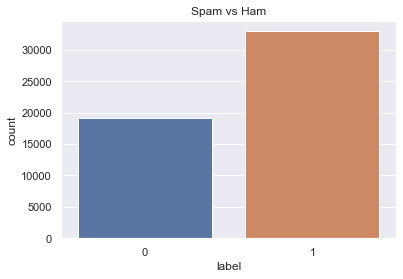

In [24]:
sns.countplot(x = "label", data = emails_df)
emails_df.loc[:, 'label'].value_counts()
plt.title('Spam vs Ham')

In [25]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(emails_df['content'], emails_df['label'], test_size = 0.25, random_state = 37)

In [27]:
cv = CountVectorizer(analyzer=text_process)

In [28]:
cf_train = cv.fit(X_train)

In [30]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [31]:
from sklearn.naive_bayes import MultinomialNB
mb = MultinomialNB(alpha = 0.5)
#print (X_train_cv.shape, y_train.shape)
mb.fit(X_train_cv,y_train)
y_pred = mb.predict(X_test_cv)

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
print('Naive Bayes Accuracy: ', accuracy_score( y_pred , y_test))
print('Naive Bayes confusion_matrix: \n', confusion_matrix(y_pred, y_test))
print('Precision:', precision_score(y_test,y_pred))

Naive Bayes Accuracy:  0.9887830362630609
Naive Bayes confusion_matrix: 
 [[4767   91]
 [  55 8103]]
Precision: 0.9932581515077225


In [33]:
bow_data = cf_train.transform(emails_df['content'])

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(bow_data)

In [35]:
data_tfidf = tfidf_transformer.transform(bow_data)


In [36]:
import numpy as np
np.shape(data_tfidf)

(52062, 190386)

In [37]:
from sklearn.model_selection import train_test_split

data_tfidf_train, data_tfidf_test, label_train, label_test = train_test_split(data_tfidf, emails_df["label"], test_size=0.3, random_state=5)
#data_tfidf_train
#data_tfidf_test

In [38]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
data_tfidf_train_sc = scaler.fit_transform(data_tfidf_train)
data_tfidf_test_sc  = scaler.transform(data_tfidf_test)

In [39]:
spam_detect_model = mb.fit(data_tfidf_train, label_train)
pred_test_MNB = spam_detect_model.predict(data_tfidf_test)
acc_MNB = accuracy_score(label_test, pred_test_MNB)
print(acc_MNB)

0.9921890005762213
